In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

In [3]:
!cd data && unzip stock-time-series-20050101-to-20171231

unzip:  cannot find or open stock-time-series-20050101-to-20171231, stock-time-series-20050101-to-20171231.zip or stock-time-series-20050101-to-20171231.ZIP.


In [4]:
"""
REMEMBER TO DOWNLOAD THE DATASET AT KAGGLE AT THIS LINK:
https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231
"""
amazon="data/AMZN_2006-01-01_to_2018-01-01.csv"
ibm="data/IBM_2006-01-01_to_2018-01-01.csv"
df = pd.read_csv(ibm)

window_size = 21

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [6]:
close_prices = df["Close"]
scaler = StandardScaler()

close_prices_arr = np.array(close_prices).reshape(-1, 1)
close_prices = scaler.fit_transform(close_prices_arr)

close_prices_unscaled = df["Close"]

In [7]:
def create_timestamps_ds(series, 
                         timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)
    
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    
    #feed the timestamps list
    for i in range(len(series)-1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))
    
    #feed the labels lsit
    for i in range(len(series)-1):
        labels.append(series[i + 1])
    
    assert len(time_stamps) == len(labels), "Something went wrong"
    
    #torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()
    
    return features, labels

In [8]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [9]:
Xs, ys = create_timestamps_ds(close_prices)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%250==0:
            preds_test = net(X_test)[:,0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

Iteration: 250 Val-loss: 0.1738
Iteration: 500 Val-loss: 0.0059
Iteration: 750 Val-loss: 0.0086
Iteration: 1000 Val-loss: 0.0056
Iteration: 1250 Val-loss: 0.0101
Iteration: 1500 Val-loss: 0.0095
Iteration: 1750 Val-loss: 0.0056
Iteration: 2000 Val-loss: 0.0064
Iteration: 2250 Val-loss: 0.0035
Iteration: 2500 Val-loss: 0.0035
Iteration: 2750 Val-loss: 0.0046


In [11]:
#pred_unscaled
original = close_prices_unscaled[1:][window_size:]

In [12]:
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [13]:
def pred_stock_future(X_test,
                                           future_length,
                                           sample_nbr=10):
    
    #sorry for that, window_size is a global variable, and so are X_train and Xs
    global window_size
    global X_train
    global Xs
    global scaler
    
    #creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    idx_pred = np.arange(len(X_train), len(Xs))
    
    #predict it and append to list
    for i in range(len(X_test)):
        #print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

In [14]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler
    
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    #print(pred_std)
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [15]:
future_length=7
sample_nbr=4
ci_multiplier=5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [16]:
y = np.array(df.Close[-750:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)

print("{} our predictions are in our confidence interval".format(np.mean(total)))

0.9053333333333333 our predictions are in our confidence interval


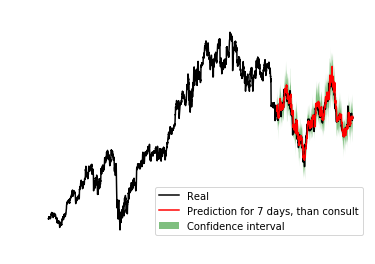

In [17]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")

plt.plot(df_pred.index,
         df_pred.Close,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.legend()

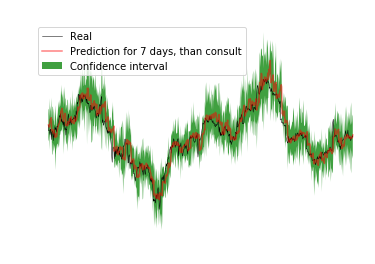

In [18]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red",
         alpha=0.5)

plt.legend()